

# Parameter estimation with nonlinear regression

Nonlinear models are abundant in reaction engineering. For example,  $r = k C_A^n $ is linear in the $k$ parameter, and nonlinear in $n$.

Nonlinear fitting is essentially a non-linear optimization problem. Unlike linear regression, where we directly compute the parameters using matrix algebra, we have to provide an initial guess and iterate to the solution in non-linear regression.

Similar to using fsolve, we must define a function of the model. The function takes an independent variable, and parameters, f(x, a, b,&#x2026;). The function should return a value of $y$ for every value of $x$, i.e. it should be vectorized.

It is possible to formulate these problems as nonlinear minimization of summed squared errors. See [this example](http://jkitchin.github.io/blog/2013/02/18/Nonlinear-curve-fitting/). The function [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) provides nonlinear fitting of models (functions) to data.

Here is an example usage. We are given some data and we want to fit the function $f(x) = \frac{a x}{b + x}$ to the data and find the values of $a$ and $b$.



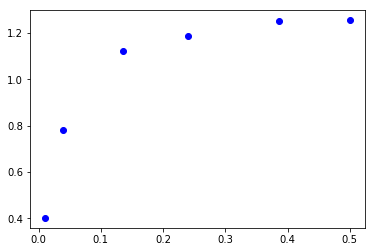

In [7]:
import numpy as np
from scipy.optimize import curve_fit

x = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
y = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x,y,'bo ')

In [9]:
# this is the function we want to fit to our data
def func(x, a, b):
    'nonlinear function in a and b to fit to data'
    return a * x / (b + x)

In [16]:
# x = 1, func returns one value
func(x=1, a=1, b=1)

0.5

In [18]:
# x = an array, func returns an array of values
func(x=np.array([1, 2]), a=1, b=1)

array([ 0.5  ,  0.667])

In [23]:
func(x, 1.2, 0.1) - y

array([-0.255, -0.296, -0.342, -0.432, -0.44 , -0.283])

In [24]:
initial_guess = [1, 2]

pars, pcov = curve_fit(func, x, y, p0=initial_guess)

a, b = pars
print('a = {0} and b={1}'.format(a, b))

a = 1.3275314289266469 and b=0.02646155910186084


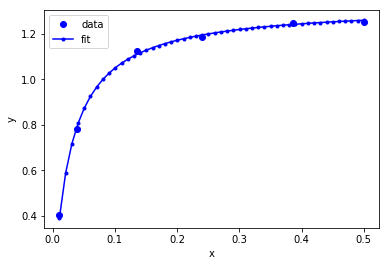

In [27]:
xfit = np.linspace(min(x), max(x))
yfit = func(xfit, *pars)  # New syntax!!!
yfit = func(xfit, a, b) 
plt.plot(x, y, 'bo')
plt.plot(xfit,yfit, 'b.-')
plt.legend(['data', 'fit'], loc='best')
plt.xlabel('x')
plt.ylabel('y')

You should always visually inspect the fit. Consider this different guess.



In [29]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array
        for functions with k predictors.
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the function
        c

a = 1.3275314302748182 and b=0.026461559303024948


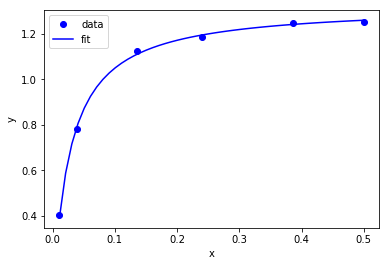

In [39]:
initial_guess = [0.1, 0.2]

pars, pcov = curve_fit(func, x, y, p0=initial_guess, bounds=((-np.inf, 0), (np.inf, np.inf)))

a, b = pars
print('a = {0} and b={1}'.format(a,b))

plt.plot(x,y,'bo ')
xfit = np.linspace(min(x), max(x))
yfit = func(xfit, *pars)
plt.plot(xfit,yfit,'b-')
plt.legend(['data','fit'],loc='best')
plt.xlabel('x')
plt.ylabel('y')

What has happened here is the $b$ parameter became negative, and so there is a division by zero. It is still a fit in the sense that there is a local minimum in summed squared error. However, we need to know if a negative $b$ parameter has any physical meaning. If the units are volume, concentration, etc&#x2026;, it may not be physically meaningful.


# Uncertainty in nonlinear regression

We also need to estimate uncertainties in nonlinear parameters

-   `pycse` provides [pycse.nlinfit](https://www.google.com/#safe=off&q=pycse.nlinfit) for this.

Here is an example usage of nlinfit.



In [51]:
np.set_printoptions(precision=3)
from pycse import nlinfit

x = np.array([0.5, 0.387, 0.24, 0.136, 0.04, 0.011])
y = np.array([1.255, 1.25, 1.189, 1.124, 0.783, 0.402])


def func(x, a, b):
    'nonlinear function in a and b to fit to data'
    #return a * x / (b + x)
    return a + b/x
initial_guess = [1.2, 0.03]
alpha = 0.001
pars, pint, se = nlinfit(func, x, y, initial_guess, alpha)
aint, bint = np.array(pint)
print('The 95% confidence interval on a is {0}'.format(aint))
print('The 95% confidence interval on b is {0}'.format(bint))

The 95% confidence interval on a is [ 0.74   1.675]
The 95% confidence interval on b is [-0.021  0.003]


In [55]:
??nlinfit

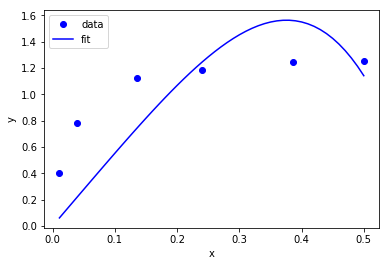

In [48]:
plt.plot(x,y,'bo ')
xfit = np.linspace(min(x), max(x))
yfit = func(xfit, *pars)
plt.plot(xfit,yfit,'b-')
plt.legend(['data','fit'],loc='best')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
pip install -U pycse==1.6.3

Here the two intervals are relatively small, and do not include zero, suggesting both parameters are significant. More importantly, the errors are not skewed by a nonlinear transformation.

Note you have to provide an initial guess. This will not always be easy to guess, and a linear regression may be a good way to get a good guess. There may be more than one minimum in the fit also, so different guesses may give different parameters.


# Differential flow reactors for determining rate laws

For many reactions it is not feasible to perform batch reactions. Especially for gas phase reactions on catalysts, a flow reactor is preferrable. If we can use a packed bed reactor with an approximately differential (i.e. a small thickness), then it is possible to directly measure the rate of reaction:

$ \frac{dF_A}{dW} = r_A $

We approximate the rate as:

$ r_A \approx \frac{F_{A,exit} - F_{A0}}{W_b} $

where $W_b$ is the weight of the bed, $F_{A,exit} = \nu C_A$ is the molar flow of $A$ out of the reactor, and $F_{A0}$ is the molar flow entering the reactor.

It is important that $W_b$ is small, to keep the total conversion as small as possible while still being able to measure changes in the molar flows. Low total conversion is important so you can assume $C_A$ is essentially constant in the reactor bed.  Instead of measuring a small change in the reactants, you may also measure the increase in molar flow rate of products, which increase from zero (assuming they are not in the feed).

In this reactor setup, you measure $r_A$ as a function of inlet conditions, and then fit the data to a proposed rate law.  Here is an example of rate data from a differential reactor as a function of inlet concentration of $A$.  We assume that $r_1 = k C_A^\alpha$ and fit the model to the data.



In [53]:
C_A = np.array([1.0, 4.0, 2.0, 0.1, 0.5])    # mol/m^3
r_1 = np.array([1.2, 2.0, 1.36, 0.36, 0.74]) # mol/m^3/min

def rate(Ca, k, alpha):
    return k * Ca**alpha

p, pint, se = nlinfit(rate, C_A, r_1, p0=[10, 0.5], alpha=0.05)
print('Estimated parameters are k={}, alpha={}'.format(*p))
print('At the 95% confidence level:')
print('k is between {0}'.format(pint[0]))
print('alpha is between {0}'.format(pint[1]))

Estimated parameters are k=1.067250291500129, alpha=0.4461986323686289
At the 95% confidence level:
k is between [ 0.9    1.234]
alpha is between [ 0.304  0.588]


In [54]:
?nlinfit


# Role of uncertainty in reactor design

What should we do with the knowledge of uncertainty? We can use it to estimate the uncertainty in reactor design. Let's consider the design of a batch reactor that should convert 80% of reactant A in the time it is run. The question is how long should we run it? We want to be sure we achieve 80% conversion, but not run too long, since it costs money to do that. Let us use the rate law we just determined, and assume we start with an initial concentration of $A$ of 1.5M. First, we solve for the time using the estimated parameters. We can solve for the time here as:

$t = \int_{C_{A0}}^{C_A} \frac{dC_A}{-k C_A^\alpha}$



In [1]:
Ca0 = 1.5 # M
X = 0.8
Ca = Ca0 * (1 - X)

from scipy.integrate import quad

def objective(ca, k, alpha):
    return 1 / (-k * ca**alpha)
a1, _ = quad(objective, Ca0, Ca, args=(p[0], p[1]))
print('t1 = {} minutes'.format(a1))

t1 = 1.2492920712809759 minutes

Now, what about the uncertainty though? We have uncertainty in k and alpha. Let's calculate the time for all the combinations of k and alpha to see what range of times might conceivably be possible. We can do that by looping over the confidence interval ranges and computing the times.



In [1]:
for k1 in pint[0]:
    for alpha1 in pint[1]:
        a2, _ = quad(objective, Ca0, Ca, args=(k1, alpha1))
        print('({}, {}): t2 = {} minutes'.format(k1, alpha1, a2))

(0.9000476513435338, 0.30394027629553644): t2 = 1.4262422719511303 minutes
(0.9000476513435338, 0.5884569884417213): t2 = 1.545110933698486 minutes
(1.234452931656724, 0.30394027629553644): t2 = 1.0398825051949792 minutes
(1.234452931656724, 0.5884569884417213): t2 = 1.1265504186329351 minutes

Visually we inspect this and see that the longest time it might take to get 80% conversion is 1.55 minutes. That is a worst-case scenario, and we might choose that because then we are pretty sure that we will get at least 80% conversion. That is for the smallest $k$ and largest $\alpha$. We are likely to get higher than 80% conversion in this case, because the probability that the true values of $k$ and $\alpha$ having these values is not high. The point here is that because of uncertainty, it is possible that the true time to get 80% conversion can be less than or greater than the time we estimate from the best fit parameters. 

The likelihood of achieving 80% conversion from the fitted parameters is only about 50%! To increase the likelihood, we have to run longer, and this is a simple approach to estimate how much longer. It does not tell us though, how much more certain we are. We examined the limits of the 95% confidence intervals. That does not imply we are 95% certain of reaching 80% conversion at 1.55 minutes though. To get a precise estimate of certainty, we need to use statistics and either analytical propagation of errors or Monte Carlo simulation. Both of these are outside the scope of this class.


# Summary

Important python functions to learn:

1.  [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) - use when you only want parameters of a nonlinear model
2.  [pycse.nlinfit](https://www.google.com/#safe=off&q=pycse.nlinfit) - use when you want parameters and uncertainty of a nonlinear model

Reminders:

1.  [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html)
2.  [pycse.regress](https://www.google.com/#safe=off&q=pycse.regress) - linear regression with uncertainty

